# IED Detection

This notebook detects IEDs to produce labels for our forecasting algorithms. This includes:
* Loading an EDF file containing the recordings and keeping a defined subset of all channels.
* Running an IED detection algorithm.
* Splitting the data up into different 'windows' which are then labelled with the number of IEDs that occur in the next window.
* Saving these windows and their labels (X.npy/y.npy).

In [2]:
import mne
import scipy
import scipy.io
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
import seaborn as sns

matplotlib.rcParams['figure.figsize'] = (20, 10)
mne.set_log_level('WARNING')

Open the file containing the recordings.

In [15]:
raw_fname = 'Data/TrialPatientArRa/X~ X_b14395e9-3ecc-4a6b-9c1f-f47646334c72.EDF'
# raw_fname = 'Data/TrialPatientBeSa/X~ X_74addeec-ea9c-4b25-8280-cab2db067651.EDF'

raw = mne.io.read_raw_edf(raw_fname, preload='Data/TrialPatientArRa/temp')
# raw = mne.io.read_raw_edf(raw_fname)

print(raw.info)

<Info | 7 non-empty values
 bads: []
 ch_names: EEG J12, EEG J11, EEG J10, EEG J9, EEG J8, EEG J7, EEG J6, EEG ...
 chs: 185 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 1024.0 Hz
 meas_date: 2020-12-10 23:58:27 UTC
 nchan: 185
 projs: []
 sfreq: 2048.0 Hz
>


In [51]:
raw.info['sfreq']

2048.0

In [22]:
# Load file containing suitable channels and convert to list
mat = scipy.io.loadmat('Data/TrialPatientArRa/channels.mat')
valid_channels = [channel[0] for channel in mat['channels'][:, 0]]

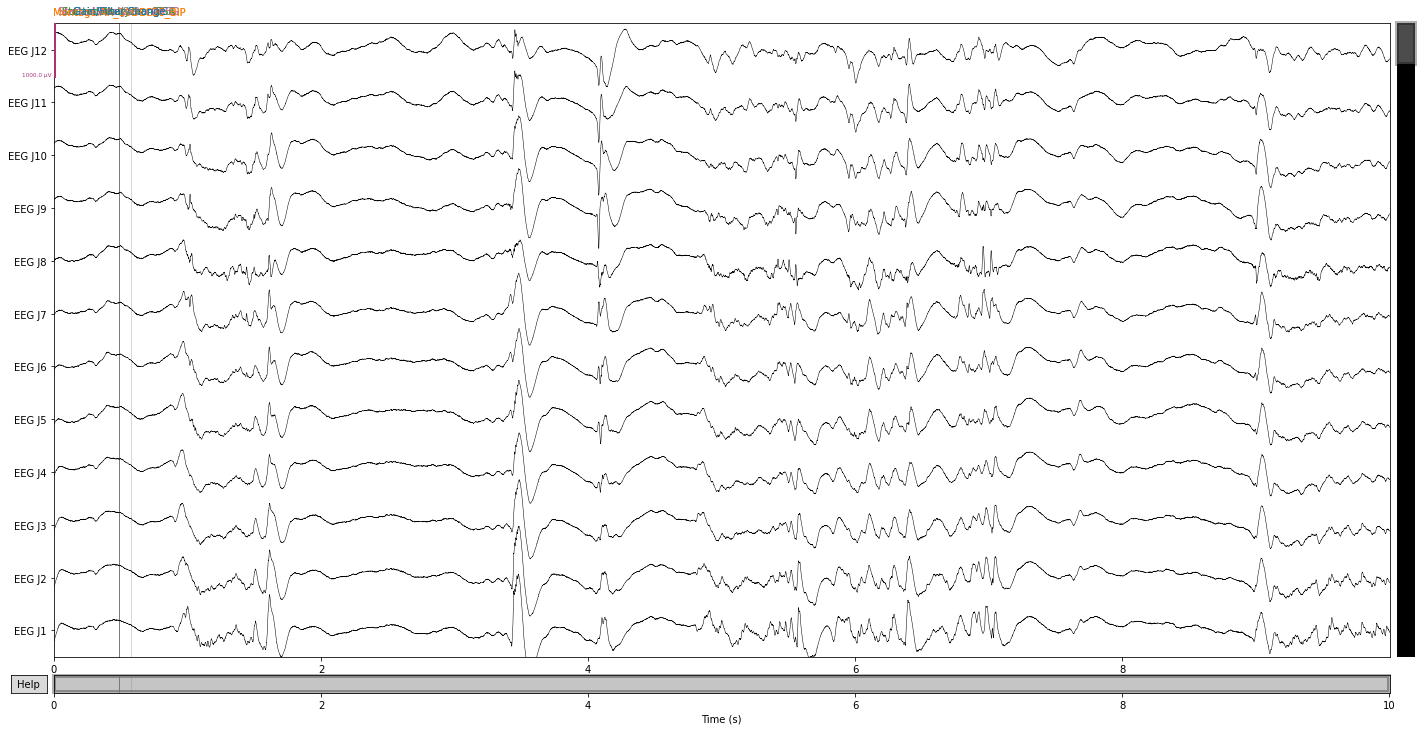

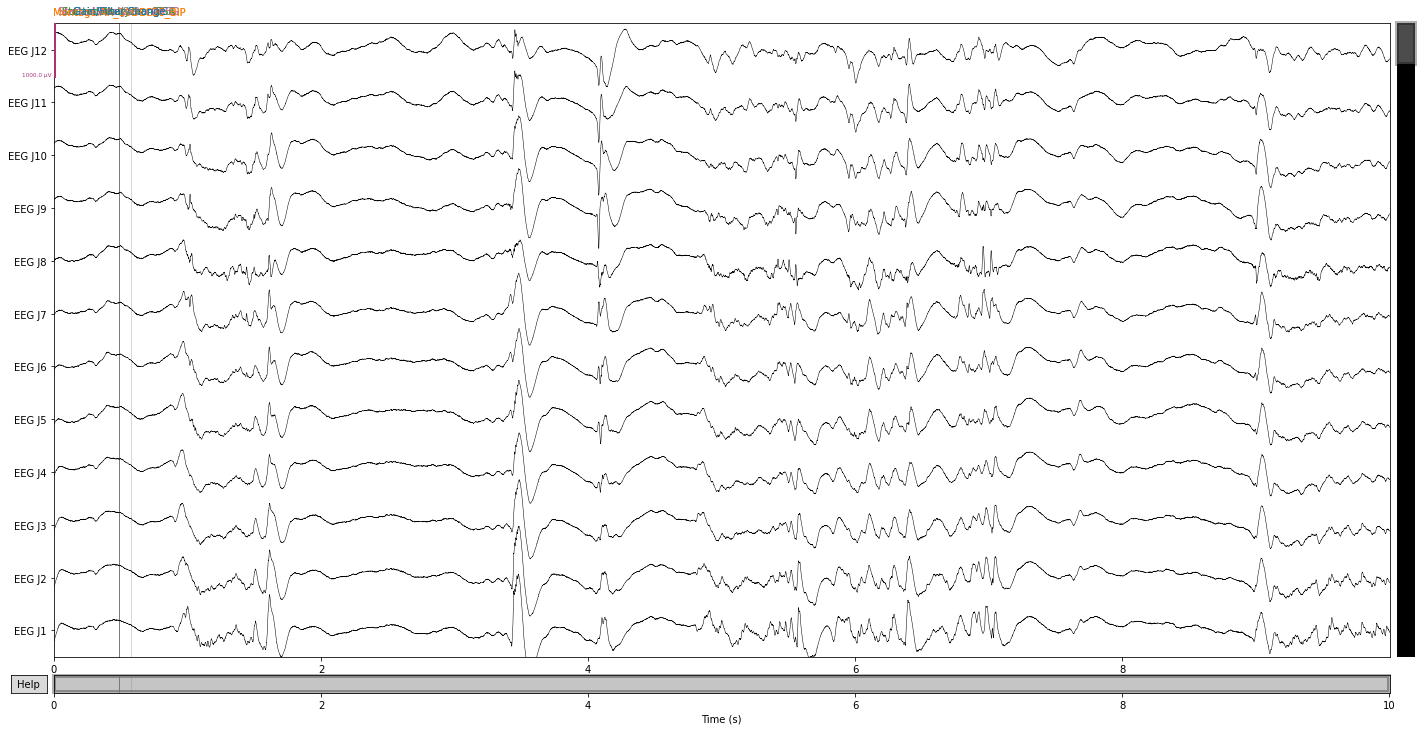

In [21]:
first_10_seconds = raw.copy().crop(0, 10)
first_10_seconds.set_eeg_reference(ref_channels=['EEG L6'])
first_10_seconds.plot(duration=10, n_channels=12, scalings=dict(eeg=5e-4))

In [25]:
%run DetectSpike_SEEG.py

In [70]:
# In minutes
BlockSize=1

# Time points
M = raw.n_times

freq = raw.info['sfreq']
ref_channels = ['EEG L6']

SpikeIds = []
ChanIds = []

# Duration of recording in seconds
NumSecs = M / freq
Blocks = math.floor(NumSecs / (BlockSize * 60))

for CurrentBlock in range(Blocks):
    Data = raw.copy().crop(CurrentBlock * BlockSize * 60, \
                           CurrentBlock * BlockSize * 60 + 60) \
    .set_eeg_reference(ref_channels=ref_channels) \
    .get_data(picks=valid_channels)
    
    SpikeIndex, ChanId, _ = DetectSpikes(Data, freq, DetThresholds=[7, 7, 300, 10, 10])
    
    # Add to list across all blocks, corrected for times
    SpikeIds.append(SpikeIndex + CurrentBlock * BlockSize * 60 * freq)
    ChanIds.append(ChanId)

In [99]:
# Convert to numpy arrays
SpikeIndex = np.concatenate(SpikeIds, axis=0)
ChanId = np.concatenate(ChanIds, axis=0)

Reference data and plot for a subset of the channels.

Reference the data and exclude noisy channels.

Load the IED detection file which contains a function called DetectSpikes.

Detect IEDs.

print(np.sort(SpikeIndex) / 512)

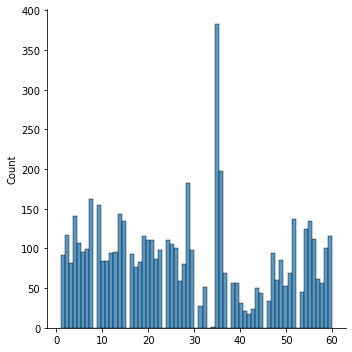

In [91]:
bins = np.arange(0, 661, 10)
dig = np.digitize(SpikeId_array / 2048, bins)
sns.displot(dig, bins=len(bins))

In [18]:
SpikeIndex.max() / 2048

3599.09765625

Plot some data and detected IEDs.

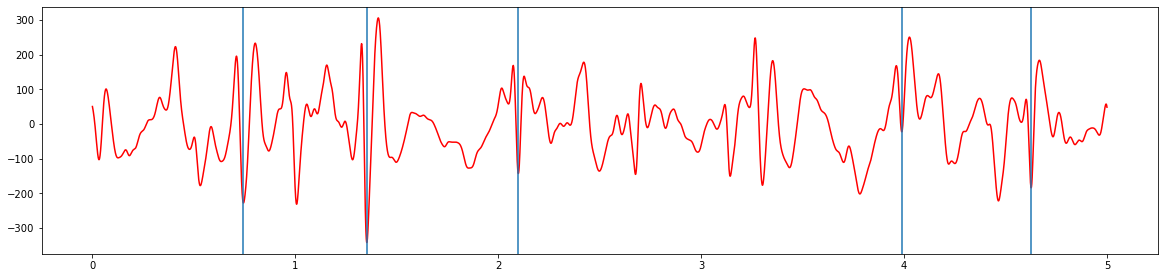

In [9]:
# How many seconds from the start of the recording to consider
seconds = 5

# Index of channel to consider
chan = 1

t = np.linspace(0.0, seconds, seconds*2048)

# Plot recording
plt.subplot(212)
plt.plot(t, Data[chan, :seconds*2048], color = 'r')

spike_indices = np.logical_and(ChanId == chan, SpikeIndex < seconds*2048)
for spike in SpikeIndex[spike_indices]:
    plt.axvline((spike)/2048)

Plot distribution of inter-IED intervals.

Text(0.5, 6.79999999999999, 'Time (s)')

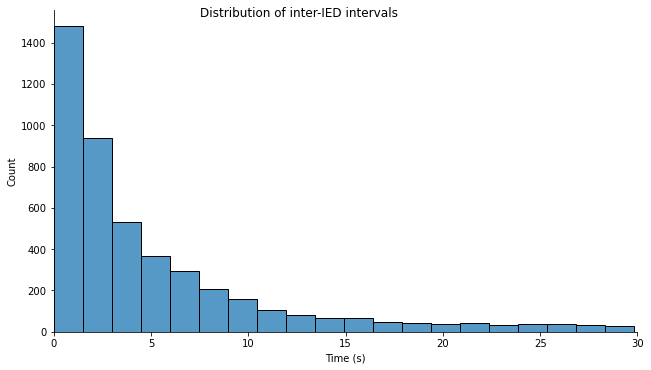

In [102]:
# Difference in time between IEDs
diffs = np.zeros((1))
for channel in np.unique(ChanId):
    diffs = np.append(diffs, np.diff(SpikeId_array[ChanId_array == channel]))

diffs = diffs[1:]

# Only keep intervals < 30s
filtered_diffs = diffs[diffs / 2048 < 30]

# Plot using histogram
g = sns.displot(filtered_diffs/2048, bins=20)

# Alternatively use kde plot
# g = sns.displot(filtered_diffs/2048, kind='kde')

g.fig.set_size_inches(10,5)
g.set(xlim=(0, 30))
g.fig.suptitle('Distribution of inter-IED intervals')
plt.xlabel('Time (s)')

Create our dataset from the labels.

In [11]:
# In Hz
freq = 2048

# How long (in seconds) our windows are
window_seconds = 10

X = []
y = []

for channel, to_split in enumerate(-Data):
    
    # number of windows
    windows = math.floor(to_split.shape[0] / (freq*window_seconds))

    # crop data and reshape to windowed dimension
    new_data = to_split[:freq*window_seconds*windows].reshape((windows, freq*window_seconds))

    # get rid of last X window 
    new_data = new_data[:-1]

    labels = np.zeros(windows)

    for spike in SpikeIndex[ChanId == channel]:
        labels[int(spike // (freq*window_seconds))] += 1

    # get rid of first label
    labels = labels[1:]
    
    # Multiplying by 1e5 and converting to float16 to save space
#     X.append((1e5 * new_data).astype(np.float16))
    X.append(new_data.astype(np.float16))
    y.append(labels)
    
X = np.concatenate(X, axis=0)
y = np.concatenate(y, axis=0)

Save as X.npy and y.npy

In [12]:
with open('X.npy', 'wb') as f:
    np.save(f, X)
    
with open('y.npy', 'wb') as f:
    np.save(f, y)